In [1]:


import numpy as np
import os

os.system('source ~/Downloads/cdf37_1-dist/src/definitions/definitions.K')
os.environ["CDF_LIB"] = '/home/jackalak/Downloads/cdf37_1-dist/lib'
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from sklearn import *

from scipy import interpolate

from ovationpyme import ovation_utilities

from ovationpyme.ovation_utilities import robinson_auroral_conductance
from ovationpyme.ovation_utilities import brekke_moen_solar_conductance

import geospacepy
from geospacepy import special_datetime,astrodynamics2,satplottools
import aacgmv2 #available on pip

%matplotlib inline  


import numpy as np
import matplotlib.pyplot as plt
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector, SeasonalFluxEstimator
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux
import ipywidgets
from collections import OrderedDict
from functools import partial



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/geospacepy-0.1.0-py3.6.egg/geospacepy/__init__.py", line 8, in <module>
    from geospacepy.geospacepy_config import config
ModuleNotFoundError: No module named 'geospacepy.geospacepy_config'

Solar wind data files will be saved to /home/jackalak/.local/share/geospacepy


In [2]:
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.sort_values(by=[ 'Datetimes'])
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c)]#] | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)
# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])

In [3]:
import pickle

with open('ovation_fluxes_val','rb') as f: ovation_fluxes_val = pickle.load(f)
with open('ovation_fluxes_train','rb') as f: ovation_fluxes_train = pickle.load(f)

In [4]:
df_val['ovation_flux_sum'] = ovation_fluxes_val[0,:]+ovation_fluxes_val[1,:]+ovation_fluxes_val[2,:]
df_train['ovation_flux_sum'] = ovation_fluxes_train[0,:]+ovation_fluxes_train[1,:]+ovation_fluxes_train[2,:]
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from sklearn import preprocessing

In [5]:
# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
#print(numFeatures)

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

for i in range(0,X_train_scaled.shape[1]):
    maxi = np.max(np.abs(X_train_scaled[:,i]))
    print(np.max(np.abs(X_train_scaled[:,i])))
    X_train_scaled[:,i] = X_train_scaled[:,i]/maxi
    X_val_scaled[:,i]= X_val_scaled[:,i]/maxi

    print(np.max(np.abs(X_train_scaled[:,i])))

1.2761205836658862
1.0
1.2284349482110106
1.0
2.25
1.0
0.738430697169635
1.0
0.7010160324370386
1.0
0.8479225543006571
1.0
0.6774962066760271
1.0
0.7076817160759405
1.0
1.2351810098965115
1.0
16.25959780621572
1.0
10.310447761194029
1.0
4.606741573033708
1.0
4.509765625
1.0
10.330434782608696
1.0
13.243243243243244
1.0
9.638297872340425
1.0
9.142857142857142
1.0
943.0
1.0
4.64754856614246
1.0
4.596100278551532
1.0
45.75238095238096
1.0
4.153116196764917
1.0
1.9732738408280353
1.0
16.170909090909092
1.0
11.382097334878331
1.0
5.410501981505944
1.0
3.892476872054459
1.0
8.463300058719907
1.0
10.502242152466371
1.0
9.182235834609495
1.0
11.843243243243244
1.0
895.0619402985076
1.0
4.402350227092486
1.0
4.383100427195716
1.0
25.02533650039589
1.0
4.356651104109752
1.0
2.0278403299058025
1.0
16.141560798548113
1.0
11.41746169413125
1.0
4.479372937293729
1.0
3.8967685589519645
1.0
7.476744186046513
1.0
10.656632173095014
1.0
7.614285714285713
1.0
11.163934426229508
1.0
917.6740627390976
1.0


In [6]:
print(y_val[y_val == 0.0001].shape)
print(y_val[y_val_erg == 0].shape)
print(df_val['ovation_flux_sum'].values[df_val['ovation_flux_sum'].values == 0].shape)
print(y_train[y_train == 0.0001].shape)
print(y_train[y_train_erg == 0].shape)
print(df_train['ovation_flux_sum'].values[df_train['ovation_flux_sum'].values == 0].shape)

(0,)
(0,)
(6937,)
(0,)
(0,)
(224305,)


In [7]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# Uncomment the below to use the GPU

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [8]:
df_val['ovation_flux_1'] = ovation_fluxes_val[0,:]
df_train['ovation_flux_1'] = ovation_fluxes_train[0,:]
df_val['ovation_flux_2'] = ovation_fluxes_val[1,:]
df_train['ovation_flux_2'] = ovation_fluxes_train[1,:]
df_val['ovation_flux_3'] = ovation_fluxes_val[2,:]
df_train['ovation_flux_3'] = ovation_fluxes_train[2,:]


# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]
#print( (feature_cols))
#print(df_cumulative.columns)

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
#print(numFeatures)

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))


(0,)
(0,)
(6937,)


(array([6.9370e+03, 0.0000e+00, 3.0000e+00, 1.0000e+01, 5.5000e+01,
        2.2600e+02, 1.1460e+03, 1.6316e+04, 2.0391e+04, 1.0126e+04]),
 array([-20.72326584, -18.46980556, -16.21634528, -13.962885  ,
        -11.70942472,  -9.45596444,  -7.20250417,  -4.94904389,
         -2.69558361,  -0.44212333,   1.81133695]),
 <a list of 10 Patch objects>)

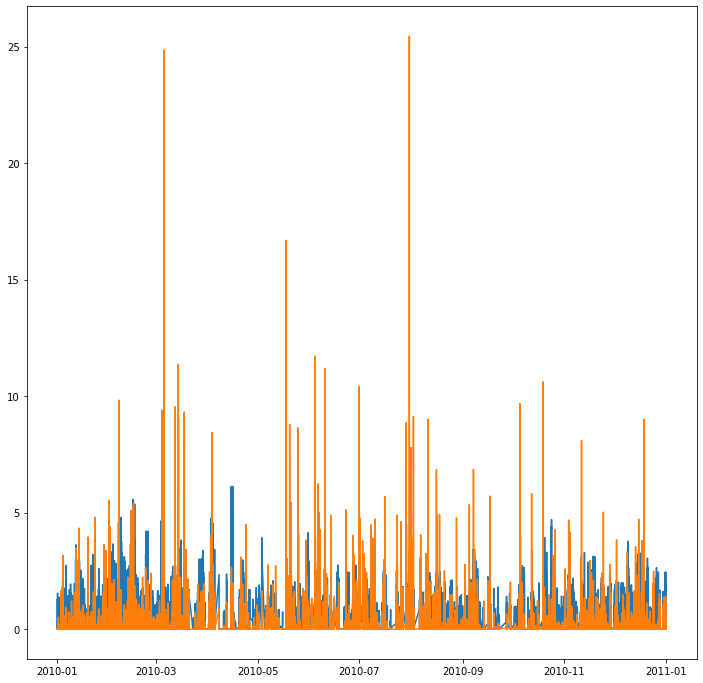

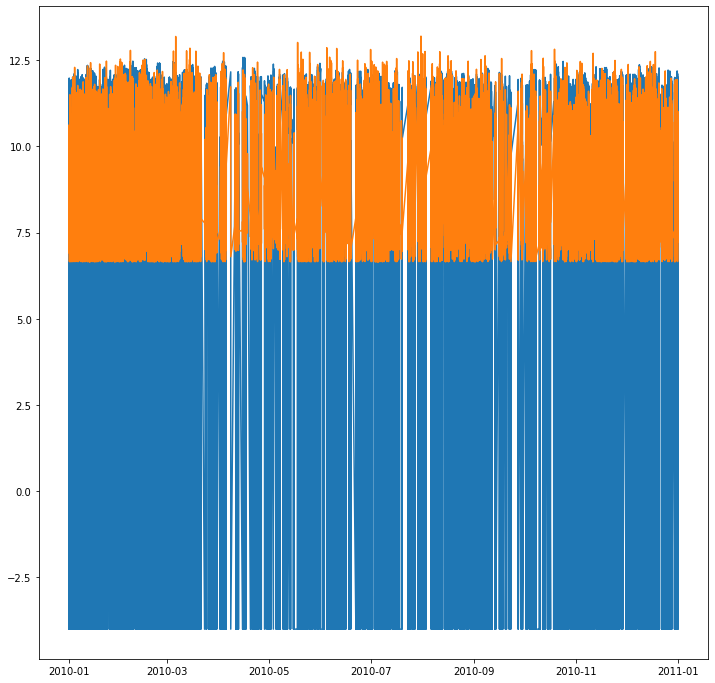

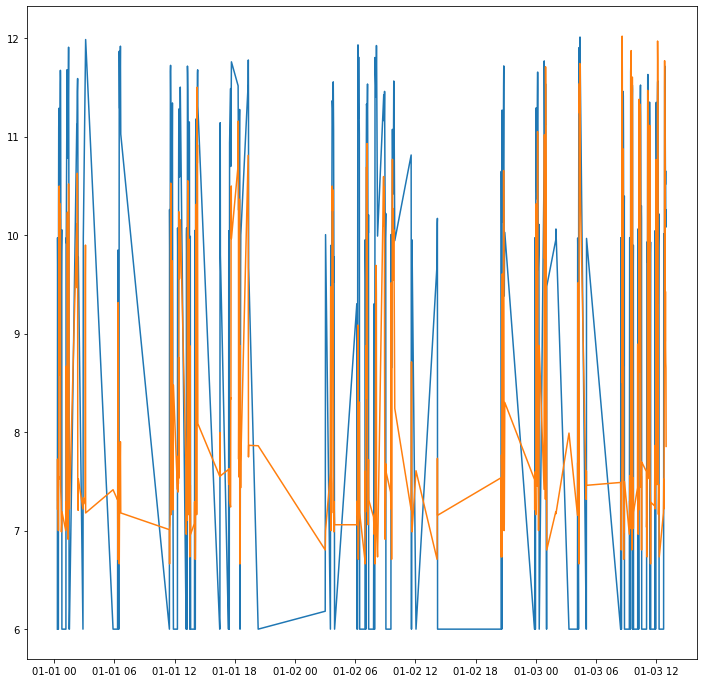

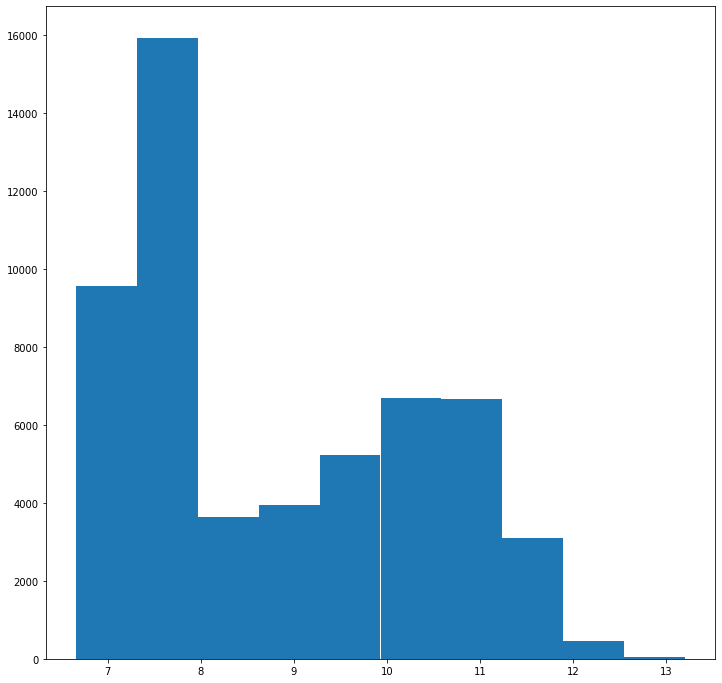

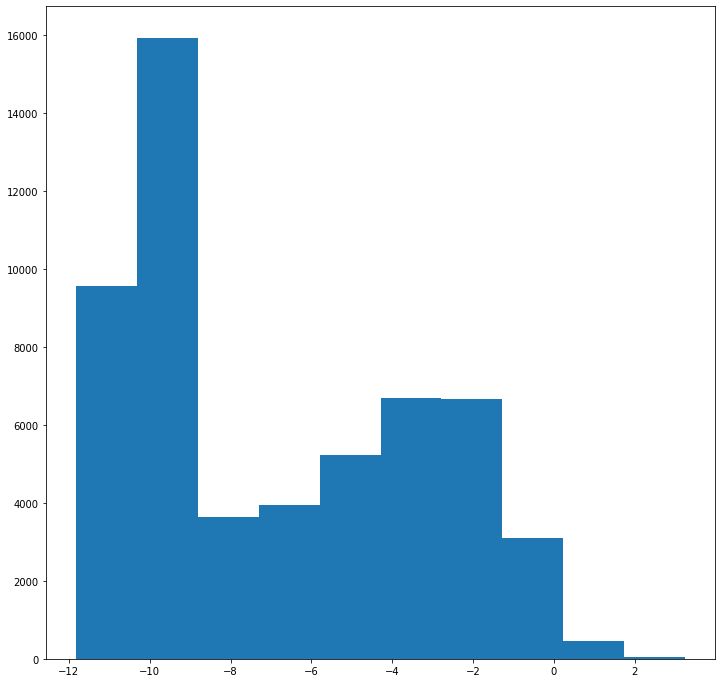

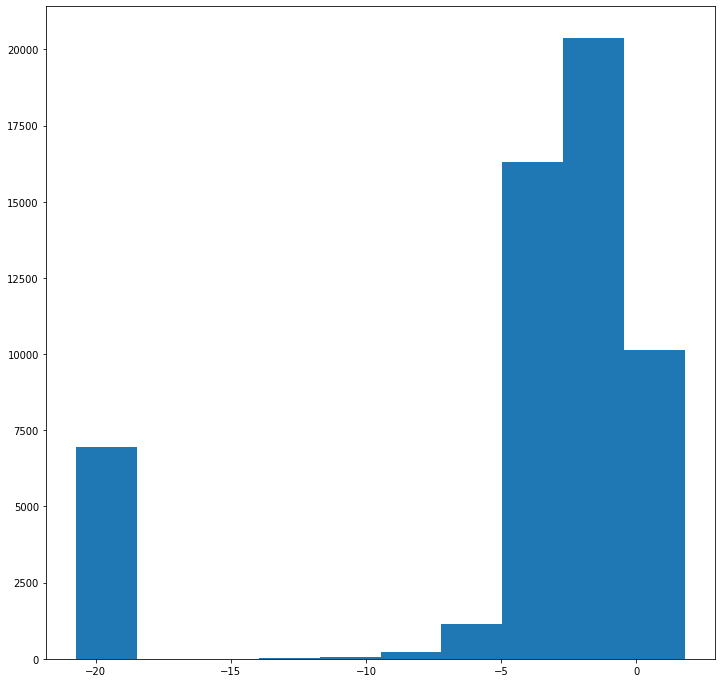

In [9]:
plt.figure(figsize=(12,12))
plt.plot(df_val['ovation_flux_sum'])
plt.plot(df_val['ELE_TOTAL_ENERGY_FLUX'] * (1.60218e-12))

plt.figure(figsize=(12,12))
plt.plot(np.log10(df_val['ovation_flux_sum']/ (1.60218e-12)+.0001))
plt.plot(np.log10(df_val['ELE_TOTAL_ENERGY_FLUX']+.0001 ))

plt.figure(figsize=(12,12))
plt.plot(np.log10(df_val['ovation_flux_sum'][:500]/ (1.60218e-12)+10**6))
plt.plot(np.log10(df_val['ELE_TOTAL_ENERGY_FLUX'][:500] +.0001))

plt.figure(figsize=(12,12))
plt.hist(y_val_log)

plt.figure(figsize=(12,12))
plt.hist(np.log(y_val_erg))
print(y_val[y_val == 0.0001].shape)
print(y_val[y_val_erg == 0].shape)
print(df_val['ovation_flux_sum'].values[df_val['ovation_flux_sum'].values == 0].shape)

plt.figure(figsize=(12,12))
plt.hist(np.log(df_val['ovation_flux_sum'].values+.000000001))

In [10]:
from tensorflow.keras.layers import Dropout
import joblib

In [11]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(4, activation='relu'))
# model.add(Dense(1))


# #compile model using accuracy to measure model performance
# model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

# for i in range(0,40):
#     model.fit(X_train_scaled, np.array(y_train_log), validation_data=(X_val_scaled, np.array(y_val_log)),batch_size=8192, epochs=100)




W0714 08:05:33.446844 140440923432768 deprecation.py:506] From /home/jackalak/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


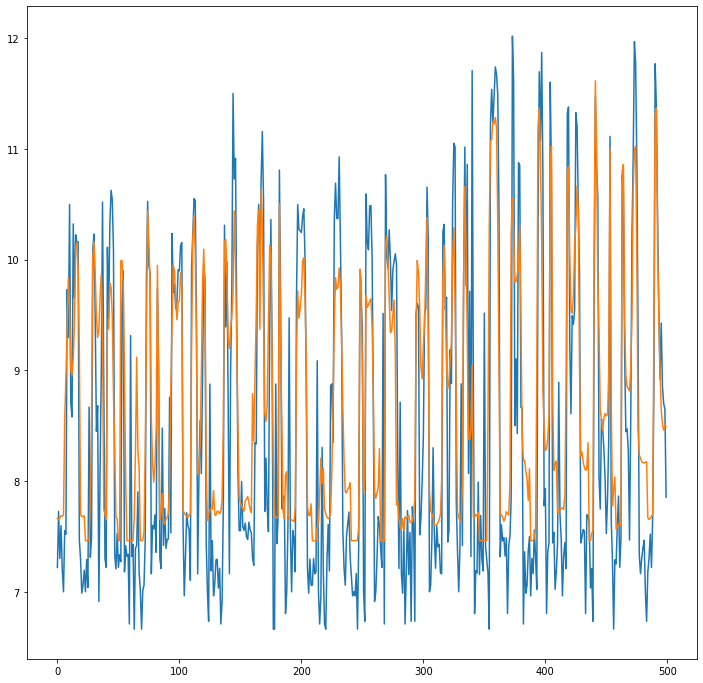

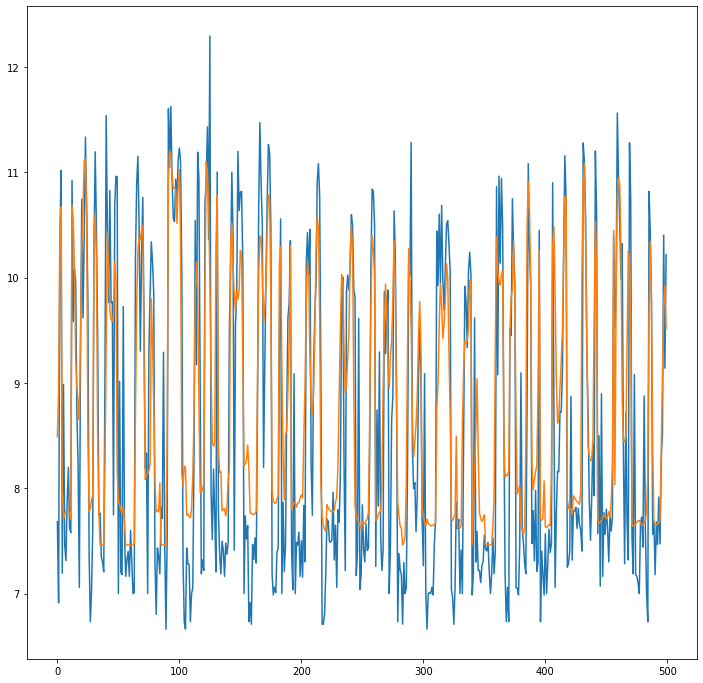

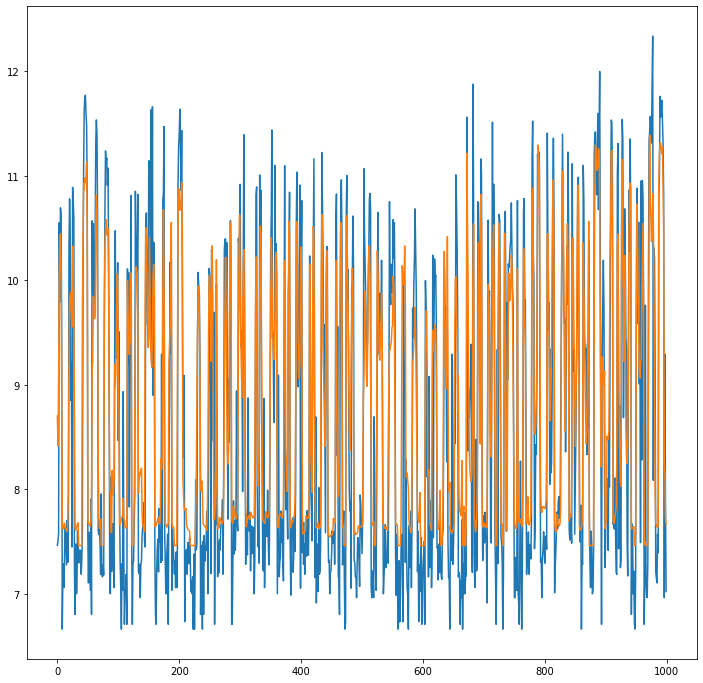

In [12]:
filename = 'best_with_ovation_input2'

model = tensorflow.keras.models.load_model(filename)
model.save(filename)
model.save_weights('my_model_weights1.h5')

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:500])
plt.plot(results[:500])
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[500:1000])
plt.plot(results[500:1000])
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[1000:2000])
plt.plot(results[1000:2000])
plt.show()

In [13]:
df_val['ovation_flux_sum'] = np.log10(ovation_fluxes_val[0,:] / (1.60218e-12) )

df_val['ovation_flux_1'] = np.log10(ovation_fluxes_val[0,:] / (1.60218e-12) )
df_train['ovation_flux_1'] = np.log10(ovation_fluxes_train[0,:]/ (1.60218e-12))
df_val['ovation_flux_2'] = np.log10(ovation_fluxes_val[1,:]/ (1.60218e-12))
df_train['ovation_flux_2'] = np.log10(ovation_fluxes_train[1,:]/ (1.60218e-12))
df_val['ovation_flux_3'] = np.log10(ovation_fluxes_val[2,:]/ (1.60218e-12))
df_train['ovation_flux_3'] = np.log10(ovation_fluxes_train[2,:]/ (1.60218e-12))


# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
#print(numFeatures)

y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in 

In [14]:
# model = Sequential()

# model.add(Dense(int(256), activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(4, activation='relu'))
# model.add(Dense(1))


# #compile model using accuracy to measure model performance
# model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

# for i in range(0,40):
#     model.fit(X_train_scaled, np.array(y_train_log), validation_data=(X_val_scaled, np.array(y_val_log)),batch_size=8192, epochs=100)


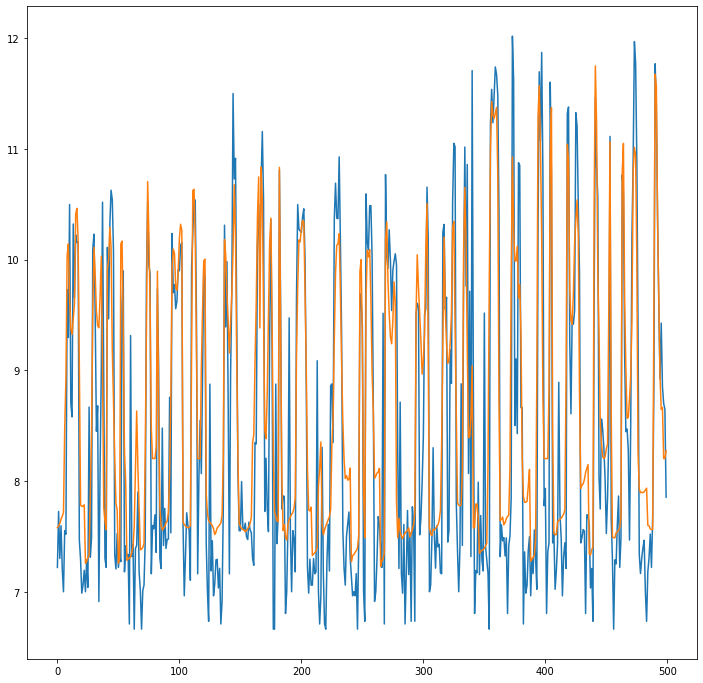

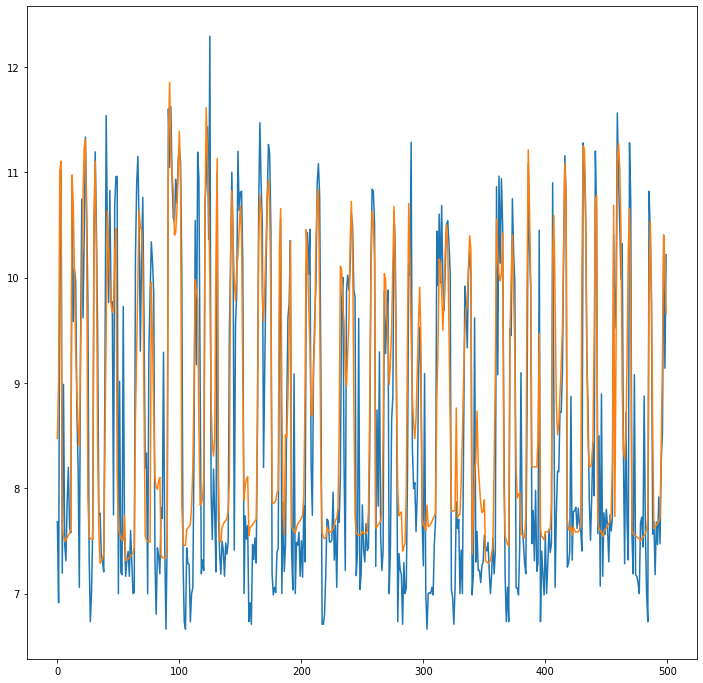

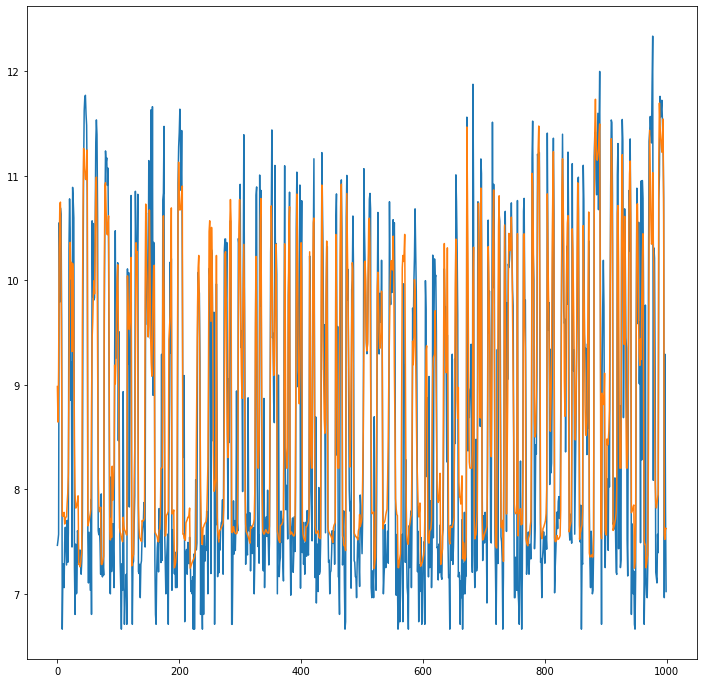

In [15]:
filename = 'best_with_ovation_input_2000epochs'

model = tensorflow.keras.models.load_model(filename)
model.save(filename)
model.save_weights('my_model_weights2.h5')

results = model.predict(X_val_scaled)#, y_val_log.values)#, batch_size=128)



plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[:500])
plt.plot(results[:500])
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[500:1000])
plt.plot(results[500:1000])
plt.show()

plt.figure(figsize=(12,12))
plt.plot(y_val_log.values[1000:2000])
plt.plot(results[1000:2000])
plt.show()